# PCB Routing with Pointer Networks


### Discuss Approach

The problem is to find closed loop routes of minimal length given a set of coordinates in a two
dimensional plane. The sets of coordinates are of differing lengths. This problem is asking 
me to implement a closed-loop Traveling Salesman Problem solver.

The problem outlined in this assignment has two constraints which were most important in guiding 
my approach:

1. The approach must be **supervised**, making use of the given dataset of instances and orders.
2. The instances and orders given are of **differing sizes**.

Constraint 2 was most crucial given that generalizing a deep learning model's routing capabilities
from one route size to another is a deeply non-trivial task. 

Given these two constraints and a search of papers in which authors implement deep learning methods
to solve Traveling Salesman Problems, I opted to implement Pointer Networks as described in this
paper [[1]](https://arxiv.org/abs/1506.03134).

### Pointer Networks

Pointer Networks address the two constraints outlined in that they are Recurrent Neural Network
models trained in a supervised manner on inputs of arbitrary length. They are similar to Seq2Seq
models in that they perform a 'translation' but differ in that the output values are not sequences
of probabilities of values from a vocabulary but rather probabilities of values from the input
sequence. That is, the output is a set of pointers, each consisting of a softmax distribution, to
values in the input sequence. 

### Import Dependencies


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import time

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

import importlib

# implementation of Pointer Network and relevant algorithms from model.py and algorithms.py
import model
import algorithms

importlib.reload(algorithms)
importlib.reload(model)

<module 'model' from '/Users/rodney/workplace/instadeep/model.py'>

### Load Instances and Orders

In [199]:
# load data
dataset_name = "instances"
instances = np.load(f"{dataset_name}.npy")
orders = np.load(f"{dataset_name}_orders.npy")

# remove padding
instances = [instance[np.all(instance > -1, axis=-1)] for instance in instances]
orders = [order[order > -1] for order in orders]

### Set GPU as Default Tensor Location

The full training of the model defined below was performed on a Kaggle Notebok for roughly 
5 hours. I did not pay for anything and used their free trial. 

In [ ]:
torch.set_default_tensor_type("torch.cuda.FloatTensor")

### Create Train-Test Split on Size-Specific Instances and Orders

I separate the given instances and orders into test and train sets for each PCB route component size. 
E.g., `len(xs_test) == 31` given we have sizes 20 through 50 and `xs_test[size_idx]` contains the test 
set for PCB boards with `(size_idx + 20)` components. This is not the most elegant method available 
(e.g. Pytorch's Dataloader) but it is simple and allows me to call sets of differing route sizes.

In [639]:
xs_train = []
xs_test = []
ys_train = []
ys_test = []

TEST_PERCENTAGE = 0.1

for size in range(20, 51):
    rand_ints = torch.rand(size=(5120, 4))

    x = [instance for instance in instances if len(instance) == size]
    x = torch.tensor(np.array(x)).type(torch.float32)
    y = [order for order in orders if len(order) == size]
    y = torch.tensor(np.array(y)).type(torch.int64)

    div_idx = int(len(x) * (1 - TEST_PERCENTAGE))

    x_train = x[:div_idx]
    x_test = x[div_idx:]
    y_train = y[:div_idx]
    y_test = y[div_idx:]

    xs_train.append(x_train)
    xs_test.append(x_test)
    ys_train.append(y_train)
    ys_test.append(y_test)

### Initialize and Train Pointer Network

The parameters defined below are taken straight from [1]. The pointer network model itself is a
rewritten copy of [[2]](https://github.com/Guillem96/pointer-nn-pytorch), an open source
implementation of [1]. The fork I made is contained
[here](https://github.com/rodneyslafuente/pcb_pointer_net). A [diff
file](https://github.com/rodneyslafuente/pcb_pointer_net/commit/b3396c4ba57b019ed4d36d959b4b9ed4484fac82)
shows the differences between the two implementations. My changes consisted of:

- Reformatting the code.
- Altering the output such that the Pointer Network module does not compute and output its own loss
but rather outputs only its computed pointers. This way, loss is computed in separate training code
below. 
- Altering the input such that the embedded input has two dimensions instead of one. The original
implementation was made to learn to sort arrays of integers, and consequently its embedded input
size was constrained to one value per time step. This was expanded to two in order for the model to
handle two-dimensional coordinates.
- Simplifying trained parameters such that the number of attention units is equal to the hidden size
of the model.

In [ ]:
HIDDEN_SIZE = 256
BATCH_SIZE = 128
EPOCHS = 150

ptr_net = model.PCBPointerNet(HIDDEN_SIZE)
optimizer = optim.SGD(ptr_net.parameters(), lr=1.0)


def loss_func(pointers_batch: torch.Tensor, batch_y: torch.Tensor) -> torch.Tensor:
    """
    Compute batch loss for a set of pointers and ground truth values.

    :param Tensor pointers_batch: Batch of pointers (batch_size, num_nodes, num_nodes)
    :param Tensor batch_y: Ground truth values (batch_size, num_nodes)
    :return: Batch loss
    """
    loss = 0.0
    for i in range(pointers_batch.shape[1]):
        loss += nn.functional.cross_entropy(pointers_batch[i], batch_y[i])
    return loss


test_losses = torch.zeros((EPOCHS, 31))


for epoch in tqdm(range(EPOCHS)):
    for size_idx in range(31):
        # retrieve size-specific datasets
        x_train, x_test, y_train, y_test = (
            xs_train[size_idx],
            xs_test[size_idx],
            ys_train[size_idx],
            ys_test[size_idx],
        )

        # fit batched size-specific training data
        num_batches = len(x_train) // BATCH_SIZE

        for batch in range(num_batches):
            optimizer.zero_grad()

            start_idx = batch * BATCH_SIZE
            end_idx = start_idx + BATCH_SIZE
            batch_x, batch_y = x_train[start_idx:end_idx], y_train[start_idx:end_idx]

            pointers_batch = ptr_net(batch_x)
            loss = loss_func(pointers_batch, batch_y)
            loss.backward()

            nn.utils.clip_grad_norm_(ptr_net.parameters(), 2.0)

            optimizer.step()

        # record loss on batched size-specific testing data
        with torch.no_grad():
            pointers_batch = ptr_net(x_test)
            loss = loss_func(pointers_batch, y_test)
            test_losses[epoch][size_idx] = loss

    # Rewrite test losses, save model after every epoch
    torch.save(test_losses, "test_losses")
    torch.save(ptr_net.state_dict(), "ptr_net_{}.pt".format(epoch + 1))

##### Plot mean test_losses for all sizes over epochs

The first big decline around epoch 5 corresponds to the model learning that every order begins with 
0 as specified in the dataset. The second sharp decline around epoch 40 was more difficult to interpret, but 
my guess is that the model learned to compute euclidean distances and employed a greedy algorithm of sorts.

In [649]:
torch.set_default_tensor_type("torch.FloatTensor")

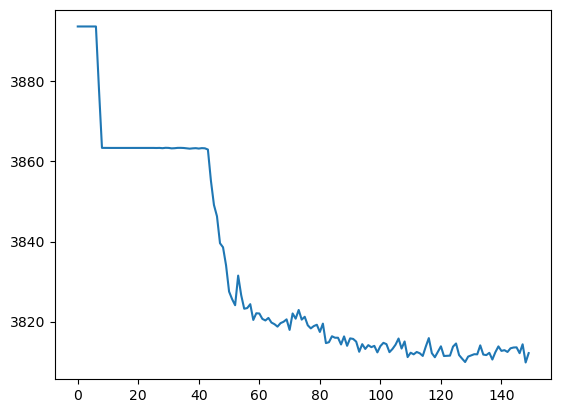

In [6]:
test_losses = torch.load("test_losses", map_location=torch.device("cpu"))

plt.plot(test_losses.sum(1))

### Evaluate Model

##### Define route finding methods

I define four routing methods and a route cost computation utility function:

1. Randomly generate the route.
2. Use a trained Pointer Network to generate the route.
3. Use the 2-Opt algorithm to generate the route, initialized on a random route.
4. Use a trained Pointer Network to generate the route and then run the 2-Opt algorithm on it.

For the PCB routing method that employs the pointer network, pointers returned by the model are decoded into
routes through a greedy algorithm. Pointers returned are of shape `(batch_size, route_size, route_size)`
where the route_size is the number of positions inputted into the model and every column in the last dimension sums to one, as the values have been softmax-ed to be interpreted as probabilities. In order to decode this into 
a batch of routes of shape `(batch_size, route_size)`, PCB components at time `t` are chosen 
greedily. That is, the index of the maximum probability of the first pointer is chosen as the first 
PCB component in the route, and that index is made ineligible from all future pointers. The second
PCB component is the index of the maximum probability of the second pointer, and so on.


In [650]:
def route_costs(positions_set: torch.Tensor, orders: np.ndarray):
    """
    Compute the length, or cost, of a given set of routes (orders) and nodes (positions).

    :input Tensor positions_set: Set of positions (batch_size, num_nodes, num_nodes)
    :input ndarray orders: Set of orders (batch_size, num_nodes)
    :return: Route costs (batch_size, )
    """

    costs = []

    for positions, order in zip(positions_set, orders):
        distance_matrix = algorithms.make_dist_matrix(positions)
        costs.append(algorithms.cost(order, distance_matrix))

    return costs


def random_routes(num_routes: int, route_length: int):
    """
    Randomly generate valid routes

    :input int num_routes: Number of routes to generate
    :input int route_length: Number of nodes in each route
    :return: List of randomly generated routes
    """

    routes = []

    for _ in range(num_routes):
        route = np.argsort(np.random.rand(route_length))
        routes.append(route)

    return routes


def route_boards_pointer_net(positions_set: torch.Tensor, pointer_network: nn.Module):
    """
    Generate routes using a given trained Pointer Network

    :input Tensor positions_set: Set of positions (batch_size, num_nodes, num_nodes)
    :input nn.Module pointer_network: Pointer Network Pytorch model
    :return: Tuple of list of generated routes and list corresponding costs
    """

    pointers_set = pointer_network(positions_set)

    routes = []

    for pointers in pointers_set:
        route = algorithms.greedily_decode_pointers(pointers)
        routes.append(route)

    costs = route_costs(positions_set, routes)

    return routes, costs


def route_boards_two_opt(positions_set: torch.Tensor):
    """
    Generate routes using the 2-Opt heuristic algorithm

    :input Tensor positions_set: Set of positions (batch_size, num_nodes, num_nodes)
    :return: Tuple of list of generated routes and list corresponding costs
    """

    routes = []
    costs = []

    for positions in positions_set:
        # Randomly select a route
        route = np.argsort(np.random.rand(len(positions)))

        distance_matrix = algorithms.make_dist_matrix(positions)
        route, cost = algorithms.two_opt(route, distance_matrix)

        routes.append(route)
        costs.append(cost)

    return routes, costs


def route_boards_pointer_net_and_two_opt(
    positions_set: torch.Tensor, pointer_network: nn.Module
):
    """
    Generate routes a given Pointer Network and the 2-Opt heuristic algorithm

    :input Tensor positions_set: Set of positions (batch_size, num_nodes, num_nodes)
    :input nn.Module pointer_network: Pointer Network Pytorch model
    :return: Tuple of list of generated routes and list corresponding costs
    """

    pointers_set = pointer_network(positions_set)

    routes = []
    costs = []

    for pointers, positions in zip(pointers_set, positions_set):
        route = algorithms.greedily_decode_pointers(pointers)

        distance_matrix = algorithms.make_dist_matrix(positions)
        route, cost = algorithms.two_opt(route, distance_matrix)

        costs.append(cost)
        routes.append(route)

    return routes, costs

##### Time and evaluate route finding methods

I time an evaluate the methods for route sizes 20, 30, 40, and 50. For each size-specific dataset
I include the mean cost of randomly generated routes to contrast with. Given a test percentage of 
10%, each size-specific dataset has 3500 * .9 = 3150 data points.

In [638]:
ptr_net = model.PCBPointerNet(HIDDEN_SIZE)
ptr_net.load_state_dict(torch.load("ptr_net_150.pt", map_location=torch.device("cpu")))
ptr_net.eval()

for size_idx in [0, 10, 20, 30]:
    positions_set = xs_test[size_idx]
    order_set = ys_test[size_idx]

    print("route size: {}".format(size_idx + 20))

    start = time.time()
    rand_routes = random_routes(positions_set.shape[0], positions_set.shape[1])
    random_routes_costs = route_costs(positions_set, rand_routes)
    end = time.time()
    print(
        "\tmean random route cost: {}, time: {}".format(
            np.mean(random_routes_costs), end - start
        )
    )

    start = time.time()
    _, ptr_net_costs = route_boards_pointer_net(positions_set, ptr_net)
    end = time.time()
    print(
        "\tmean pointer net cost: {}, time: {}".format(
            np.mean(ptr_net_costs), end - start
        )
    )

    start = time.time()
    _, two_opt_costs = route_boards_two_opt(positions_set)
    end = time.time()
    print(
        "\tmean two opt cost: {}, time: {}".format(np.mean(two_opt_costs), end - start)
    )

    start = time.time()
    _, ptr_net_two_opt_costs = route_boards_pointer_net_and_two_opt(
        positions_set, ptr_net
    )
    end = time.time()
    print(
        "\tmean pointer net + two opt cost: {}, time: {}".format(
            np.mean(ptr_net_two_opt_costs), end - start
        )
    )

    start = time.time()
    optimal_costs = route_costs(positions_set, order_set)
    end = time.time()
    print(
        "\tmean optimal cost: {}, time: {}".format(np.mean(optimal_costs), end - start)
    )

route size: 20
	mean random route cost: 10.929983817275081, time: 0.6690340042114258
	mean pointer net cost: 5.522524449569838, time: 1.734010934829712
	mean two opt cost: 4.520460113350834, time: 11.096940994262695
	mean pointer net + two opt cost: 4.465595415830612, time: 6.4997758865356445
	mean optimal cost: 4.184939290700214, time: 0.6626107692718506
route size: 30
	mean random route cost: 16.410245055907538, time: 1.4958319664001465
	mean pointer net cost: 7.214465490835053, time: 3.796165704727173
	mean two opt cost: 5.4011123090556685, time: 45.39779090881348
	mean pointer net + two opt cost: 5.362612100733178, time: 24.623942852020264
	mean optimal cost: 5.107133962001119, time: 1.532325267791748
route size: 40
	mean random route cost: 22.177384047274078, time: 2.7006351947784424
	mean pointer net cost: 9.232249394633941, time: 7.0064780712127686
	mean two opt cost: 6.19268304347992, time: 118.72638487815857
	mean pointer net + two opt cost: 6.209644411621349, time: 66.5151557

### Results

The following table summarizes the results for the routing methods, with the durations for each
evaluation.

##### Mean Route Lengths Over Test Data Sets of Different Sizes

| Method | 20 | 30 | 40 | 50 |
| --- | --- | --- | --- | --- |
| Random | **10.93**, t=N/A | **16.41**, t=N/A | **22.18**, t=N/A | **27.50**, t=N/A |
| Pointer Net | **5.52**, t=1.73s | **7.21**, t=3.80s | **9.23**, t=7.01s | **11.15**, t=11.27s |
| 2-Opt | **4.52**, t=11.10s | **5.40**, t=45.40s | **6.19**, t=118.73s | **6.93**, t=244.09s |
| Pointer Net + 2-Opt | **4.67**, t=6.50s | **5.36**, t=24.62s | **6.21**, t=6.21 | **6.90**, t=143.31s |
| Truth | **4.18**, t=N/A | **5.11**, t=N/A | **5.93**, t=N/A | **6.61**, t=N/A |

##### Analysis

- The trained Pointer Network effectively computes routes, albeit not as optimally as the 2-Opt
algorithm. 
- When combined with 2-Opt, the Pointer Network computes routes with roughly the same optimality as
the 2-Opt algorithm on its own (this is expected, as the 2-Opt algorithm, when run on its own,  is
initialized on randomly generated routes).
- The Pointer Network computes routes much more quickly than the 2-Opt algorithm, especially for
smaller sizes. When comparing these two durations, however, it is important to keep in mind that my 2-Opt
implementation is very minimal and it could be greatly optimized.
- Perhaps the most interesting takeaway is that applying 2-Opt to routes returned by the Pointer
Network converges much more rapidly than applying 2-Opt to a random route, with roughly the same
optimality. For some cases, the Pointer-Network + 2-Opt method was more optimal than 2-Opt on its
own.

### Future Directions

- A big difference between this implementation of Pointer Networks and that found in [1] is that
this one greedily decodes pointers into orders instead of using Beam Search to do so. Beam Search 
decodes pointers into routes in a way that better optimizes for the I did not
implement Beam Search due to time constraints. Given more time, I would implement Beam Search and
contrast its performance with greedy decoding.

- I implemented most algorithms in algorithms.py using Numpy and not Pytorch as it was the quickest
way to implement them. Given more time, I would explore optimizing the performance of these
implementations by leveraging GPU usage through either Pytorch or JAX.

- I did not incorporate any reinforcement learning as I wanted to satisfy the problem description as
succinctly and efficiently as possible. Given more time and perhaps the loosening of the requirement
that the model use a dataset in a supervised manner, I would change the training paradigm by
defining loss in terms of route length directly instead of by its resemblance to the given dataset.

### References 

[1] https://arxiv.org/abs/1506.03134

[2] https://github.com/Guillem96/pointer-nn-pytorch